In [101]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('APPL_formatted.csv', index_col = 0)

In [3]:
df = df[df.index >= '1-1-2010'].dropna()

In [4]:
X = df.drop(['close','adjustedclose','day_direction'], axis = 1).shift(1).dropna()
y = df['day_direction'].iloc[1:]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8073, 37) (2019, 37)
(8073,) (2019,)


In [6]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [7]:
def feature_select(X_train,y_train,estimator,min_features,step=1):
    estimator=estimator()
    selector=RFECV(estimator,min_features_to_select=min_features,step=step)
    selector.fit(X_train,y_train)
    selector.ranking_
    feature_dict=dict(zip(X_train.columns, selector.ranking_))
    best_pred = [k for (k,v) in feature_dict.items() if v == 1]
    
    return best_pred

In [8]:
logreg_feat=feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[logreg_feat]
X_test_best_log = X_test_scaled[logreg_feat]

In [9]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

Penalty: l2
Solver: sag
Mean Cross-Val Score: 0.5157921591645854
Train Mean Accuracy: 0.520748172922086
Test Mean Accuracy: 0.5279841505695889
Recall Score: 0.313824419778002
Precision Score: 0.5325342465753424
F1 Score: 0.3949206349206349


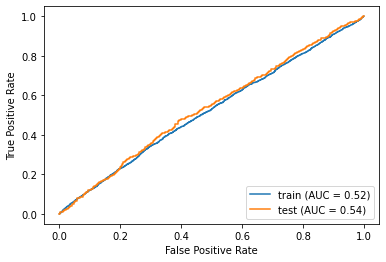

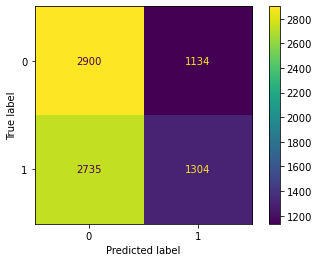

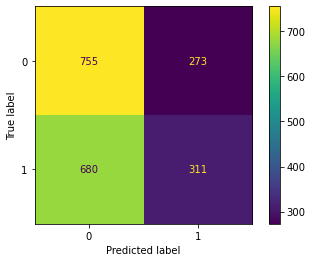

In [10]:
logreg(X_train_best_log, X_test_best_log, y_train, y_test)

In [11]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    dt_params = gs.best_params_
    
    # Use best max depth from best_params
    dt_max_depth = dt_params['max_depth']
    print(f'Max Depth: {dt_max_depth}')
    
    # Use best minimum sample split from best_params
    dt_min_samp = dt_params['min_samples_split']
    print(f'Min Sample Split: {dt_min_samp}')
    
    # Use best criterion from best_params
    dt_criterion = dt_params['criterion']
    print(f'criterion: {dt_criterion}')
    
    # Instantiate & fit Decision Tree model (don't need to do this)
   # dtree = DecisionTreeClassifier(max_depth=dt_max_depth, criterion=dt_criterion,
           #                        min_samples_split=dt_min_samp, random_state=42)
    #dtree.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

Max Depth: 15
Min Sample Split: 15
criterion: gini
Mean Cross-Val Score: 0.5170328510977861
Train Mean Accuracy: 0.6314876749659358
Test Mean Accuracy: 0.5364041604754829
Recall Score: 0.3481331987891019
Precision Score: 0.5433070866141733
F1 score: 0.4243542435424354


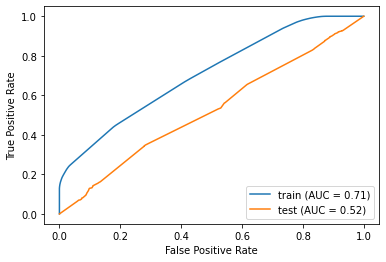

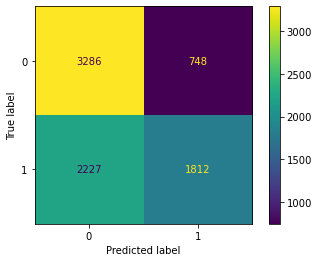

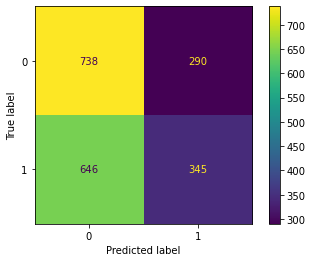

In [12]:
dtree(X_train,X_test,y_train,y_test)

In [13]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    rf_params = gs.best_params_
    
    # Use best # of trees from best_params
    rf_n_estimators = rf_params['n_estimators']
    print(f'Number of Trees: {rf_n_estimators}')
    
    # Use best criterion from best_params
    rf_criterion = rf_params['criterion']
    print(f'Criterion: {rf_criterion}')
    
    # Instantiate & fit Random Forest model(don't need to do this)
    #rforest = RandomForestClassifier(n_estimators=rf_n_estimators, criterion=rf_criterion,
                                   # random_state=42)
   # rforest.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);


In [14]:
#random_forest(X_train, X_test, y_train, y_test)

In [15]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'max_depth': [4],
    'min_child_weight': [3],
    'subsample': [1],
    'n_estimators': [100,500]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    xgb_params = gs.best_params_
    
    # Use best learning rate from best_params
    xgb_lr = xgb_params['learning_rate']
    print(f'XGBoost Learning Rate: {xgb_lr}')
    
    # Use best max depth from best_params
    xgb_max_depth = xgb_params['max_depth']
    print(f'XGBoost Max Depth: {xgb_max_depth}')
    
    # Use best min child weight from best_params
    xgb_min_child_weight = xgb_params['min_child_weight']
    print(f'XGBoost Min Child Weight: {xgb_min_child_weight}')
    
    # Use best subsample from best_params
    xgb_subsample = xgb_params['subsample']
    print(f'XGBoost Subsample: {xgb_subsample}')
    
    # Use best estimators from best_params
    xgb_estimators = xgb_params['n_estimators']
    print(f'XGBoost Estimators: {xgb_estimators}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);

XGBoost Learning Rate: 0.05
XGBoost Max Depth: 4
XGBoost Min Child Weight: 3
XGBoost Subsample: 1
XGBoost Estimators: 100
Mean Cross-Val Score: 0.5191381142556807
Train Mean Accuracy Score: 0.6404062925802056
Test Mean Accuracy Score: 0.5468053491827637
Recall Score: 0.5327951564076691
Precision Score: 0.5387755102040817
F1 score: 0.5357686453576865


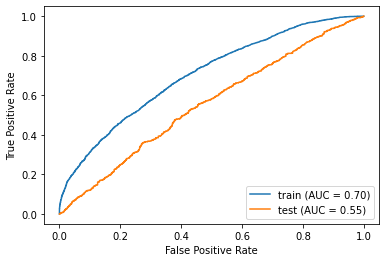

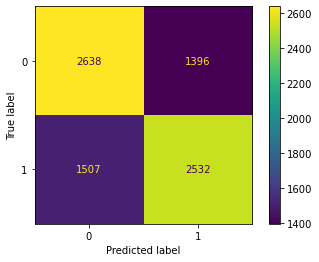

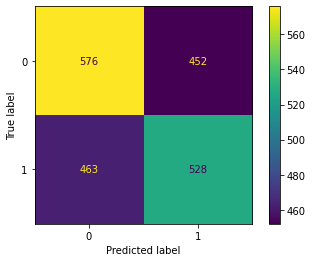

In [16]:
xgboost(X_train_scaled, X_test_scaled, y_train, y_test)